In [142]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stat

pd.set_option('display.max_columns', 9999)
%matplotlib inline

In [230]:
pts = pd.read_csv('eicu-collaborative-research-database-2.0/patient.csv.gz')
dxs = pd.read_csv('eicu-collaborative-research-database-2.0/diagnosis.csv.gz')
tm = pd.read_csv('eicu-collaborative-research-database-2.0/treatment.csv.gz')
hos = pd.read_csv('eicu-collaborative-research-database-2.0/hospital.csv.gz')
cpg = pd.read_csv('eicu-collaborative-research-database-2.0/carePlanGeneral.csv.gz')

#### Cleaning the data and adding features

In [231]:
# patients that were given pain meds
tm['painmeds'] = tm['treatmentstring'].str.contains('analgesics', case = False)
tm = tm[tm.painmeds == True]

tm.drop_duplicates(subset='patientunitstayid', inplace=True)
tm.drop(['treatmentid','treatmentoffset', 'activeupondischarge'], axis=1, inplace=True)

In [232]:
pts = pd.merge(pts, tm, on=['patientunitstayid'], how = 'left')
pts = pd.merge(pts, hos, on=['hospitalid'], how = 'left')

In [233]:
pts['treatmentstring'].fillna('no pain medications', inplace= True)
pts['painmeds'].fillna(False, inplace=True)

In [234]:
def age (x):
    if x == '> 89':
        return 90
    else:
        return int(x)
    
def pain_val (x, arr):
    try:
        return round(arr['nursingchartvalue'][x])
    except:
        return np.nan

In [235]:
pts = pts[pts.gender != 'Unknown']
pts = pts[pts.gender != 'Other']

In [236]:
pts['apacheadmissiondx'].fillna(value = 'N/A', inplace = True)
pts['hospitaladmitsource'].fillna(value = 'Unknown', inplace = True)

pts['age'].fillna(value = 0, inplace = True)
pts['age'] = pts['age'].apply(lambda x: age(x))

In [77]:
nsc = pd.read_csv('eicu-collaborative-research-database-2.0/nurseCharting.csv.gz')

In [78]:
# adding pain scores
nsc.drop(['nursingchartid', 'nursingchartoffset', 
          'nursingchartcelltypecat', 'nursingchartcelltypevallabel'], axis=1, inplace=True)
nsc = nsc[nsc['nursingchartcelltypevalname'] == 'Pain Score']

In [79]:
valid = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

nsc['nursingchartvalue'] = nsc['nursingchartvalue'].apply(lambda x: float(x))
nsc = nsc[nsc['nursingchartvalue'].isin(valid)]

nsc['nursingchartvalue'] = nsc['nursingchartvalue'].apply(lambda x: int(x))
nsc.drop(['nursingchartcelltypevalname'], axis=1, inplace=True)

In [80]:
max_pain = nsc.groupby('patientunitstayid').max()
mean_pain = nsc.groupby('patientunitstayid').mean()

In [237]:
pts['max_pain'] = pts['patientunitstayid'].apply(lambda x: pain_val(x, max_pain))
pts['mean_pain'] = pts['patientunitstayid'].apply(lambda x: pain_val(x, mean_pain))

In [238]:
# adding icd9 codes
dxs = dxs.drop(columns=['diagnosisid', 'activeupondischarge', 'diagnosisoffset', 'diagnosisstring'])
dxs.dropna(inplace=True)

# merge
dxs = dxs.groupby('patientunitstayid')['icd9code'].apply(list).reset_index(name='icd9codes')
pts = pd.merge(pts, dxs, on=['patientunitstayid'], how='left')

In [239]:
# adding ordered protocols
cpg = cpg[cpg.cplgroup == 'Ordered Protocols']
cpg.drop(columns=['cplgeneralid', 'activeupondischarge', 'cplitemoffset', 'cplgroup'], inplace = True)
cpg.drop_duplicates(inplace=True)

# merge
cpg = cpg.groupby('patientunitstayid')['cplitemvalue'].apply(list).reset_index(name='orderedprotocols')
pts = pd.merge(pts, cpg, on=['patientunitstayid'], how = 'left')

In [240]:
pts['max_pain'].fillna(value=round(pts['max_pain'].mean(skipna=True)), inplace = True)
pts['mean_pain'].fillna(value=round(pts['mean_pain'].mean(skipna=True)), inplace = True)

In [241]:
pts = pts.drop(columns=['hospitaladmittime24', 'hospitaldischargeyear', 'hospitaldischargetime24',
                       'unitadmittime24', 'dischargeweight', 'unitdischargetime24', 'uniquepid'])

In [242]:
pts = pts.dropna(axis = 0)

In [243]:
pts.head()

,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmitoffset,hospitaladmitsource,hospitaldischargeoffset,hospitaldischargelocation,hospitaldischargestatus,unittype,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,unitdischargeoffset,unitdischargelocation,unitdischargestatus,treatmentstring,painmeds,numbedscategory,teachingstatus,region,max_pain,mean_pain,icd9codes,orderedprotocols
2338,156771,140989,Female,88,Caucasian,63,95,"CVA, cerebrovascular accident/stroke",152.4,-14,Direct Admit,14457,Skilled Nursing Facility,Alive,Med-Surg ICU,Direct Admit,1,admit,64.6,724,Floor,Alive,no pain medications,False,100 - 249,f,Midwest,8.0,3.0,"[585.9, N18.9, 434.91, I63.50, 401.9, I10]",[Tissue Plasminogen Activator (tPA)]
10375,211851,183825,Female,48,Caucasian,59,91,"Thrombosis, vascular (deep vein)",170.2,-1561,Emergency Department,4064,Home,Alive,Med-Surg ICU,Floor,1,admit,68.4,2331,Floor,Alive,no pain medications,False,<100,f,Midwest,6.0,3.0,"[451.2, I80.3]",[Tissue Plasminogen Activator (tPA)]
12087,222815,192329,Female,68,Caucasian,73,89,"CVA, cerebrovascular accident/stroke",160.0,-71,Direct Admit,9514,Skilled Nursing Facility,Alive,Neuro ICU,Direct Admit,1,admit,90.8,2824,Floor,Alive,no pain medications,False,>= 500,t,Midwest,0.0,0.0,"[434.91, I63.50]",[Tissue Plasminogen Activator (tPA)]
12952,228110,196429,Male,64,Caucasian,58,108,"Infarction, acute myocardial (MI)",165.1,-114,Emergency Department,2605,Home,Alive,Med-Surg ICU,Emergency Department,1,admit,92.5,1129,Step-Down Unit (SDU),Alive,no pain medications,False,100 - 249,f,Midwest,4.0,1.0,"[786.50, R07.9, 410.71, I21.4]",[Other]
14989,242319,207482,Male,61,Caucasian,79,133,"Sepsis, other",172.7,0,Direct Admit,5896,Home,Alive,Med-Surg ICU,Direct Admit,1,admit,60.6,1856,Floor,Alive,neurologic|pain / agitation / altered mentatio...,True,>= 500,f,Midwest,6.0,2.0,"[038.9, A41.9, 205.00, C92.00, 458.9, I95.9, 4...",[Sepsis bundle]


#### Significance

In [65]:
ct_eth = pd.crosstab(pts.painmeds, pts.ethnicity, margins= True)
ct_eth

ethnicity,African American,Asian,Caucasian,Hispanic,Native American,Other/Unknown,All
painmeds,,,,,,,
False,1397,134,10527,1137,57,627,13879
True,1030,204,6679,1012,41,456,9422
All,2427,338,17206,2149,98,1083,23301


In [66]:
fobs = [1397, 134, 10527, 1137, 57, 627]
ftots = [2427, 338, 17206, 2149, 98, 1083]
fexp = np.multiply(np.sum(fobs)/np.sum(ftots),ftots)
stat.chisquare(f_obs = fobs, f_exp = fexp)

Power_divergenceResult(statistic=48.23473893538513, pvalue=3.1808223202565606e-09)

In [67]:
ct_gen = pd.crosstab(pts.painmeds, pts.gender, margins= True)
ct_gen

gender,Female,Male,All
painmeds,,,
False,6283,7596,13879
True,4127,5295,9422
All,10410,12891,23301


In [68]:
fobs = [6283, 7596]
ftots = [10410, 12891]
fexp = np.multiply(np.sum(fobs)/np.sum(ftots),ftots)
stat.chisquare(f_obs = fobs, f_exp = fexp)

Power_divergenceResult(statistic=1.978851907779156, pvalue=0.15951140815919412)

#### Figures

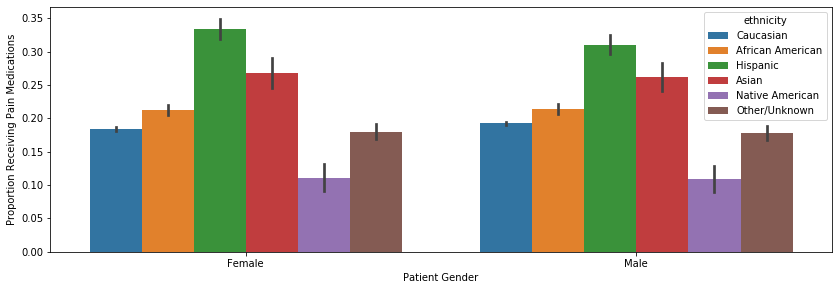

In [64]:
plt.figure(figsize=(14, 4.5))
sns.barplot(x='gender',y='painmeds',hue='ethnicity',data=pts, estimator=np.mean)
plt.xlabel('Patient Gender')
plt.ylabel('Proportion Receiving Pain Medications')
plt.savefig('figures/2A-painmeds-gender.png', dpi=300, transparent=True, bbox_inches='tight')

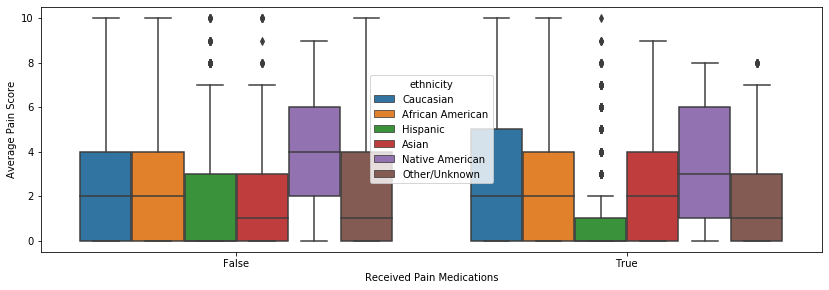

In [66]:
# must render before imputing mean and max pain values
plt.figure(figsize=(14, 4.5))
sns.boxplot(x='painmeds',y='mean_pain',hue='ethnicity',data=pts)
plt.xlabel('Received Pain Medications')
plt.ylabel('Average Pain Score')
plt.savefig('figures/2B-painscore-ethnicity.png', dpi=300, transparent=True, bbox_inches='tight')

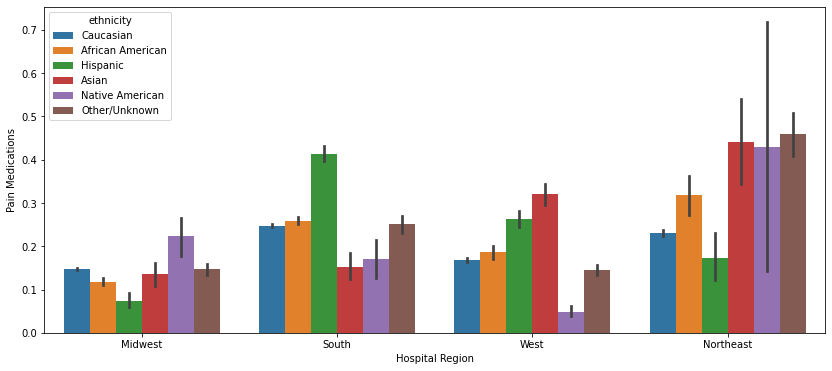

In [19]:
plt.figure(figsize=(14, 6))
sns.barplot(x='region', y='painmeds', hue='ethnicity', data=pts, estimator=np.mean)
plt.xlabel('Hospital Region')
plt.ylabel('Pain Medications')
#plt.savefig('figures/painmeds-region.png', dpi=300, transparent=True, bbox_inches='tight')

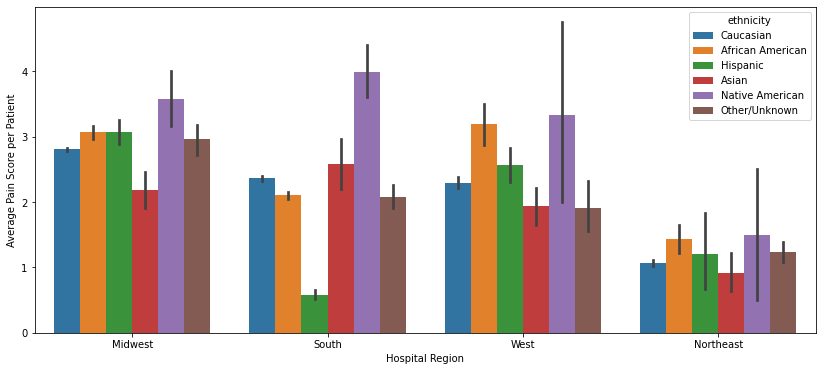

In [20]:
plt.figure(figsize=(14, 6))
sns.barplot(x='region', y='mean_pain', hue='ethnicity', data=pts, estimator=np.mean)
plt.xlabel('Hospital Region')
plt.ylabel('Average Pain Score per Patient')
#plt.savefig('figures/painmean-region.png', dpi=300, transparent=True, bbox_inches='tight')

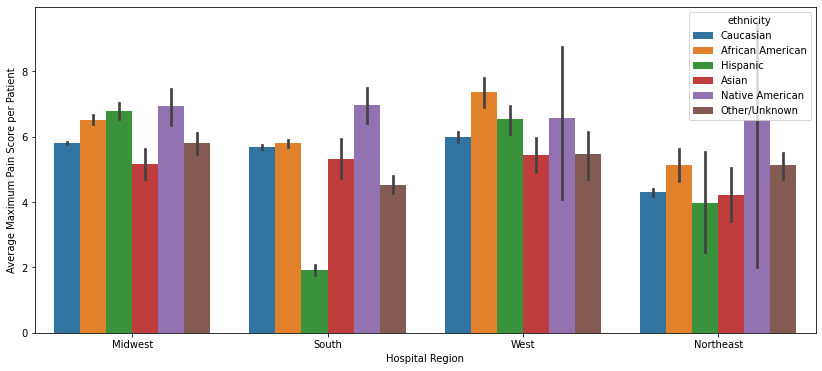

In [21]:
plt.figure(figsize=(14, 6))
sns.barplot(x='region', y='max_pain', hue='ethnicity', data=pts, estimator=np.mean)
plt.xlabel('Hospital Region')
plt.ylabel('Average Maximum Pain Score per Patient')
#plt.savefig('figures/painmax-region.png', dpi=300, transparent=True, bbox_inches='tight')

___
#### Gradient Boosting Classifier

In [20]:
pts.columns

Index(['patientunitstayid', 'patienthealthsystemstayid', 'gender', 'age',
       'ethnicity', 'hospitalid', 'wardid', 'apacheadmissiondx',
       'admissionheight', 'hospitaladmitoffset', 'hospitaladmitsource',
       'hospitaldischargeoffset', 'hospitaldischargelocation',
       'hospitaldischargestatus', 'unittype', 'unitadmitsource',
       'unitvisitnumber', 'unitstaytype', 'admissionweight',
       'unitdischargeoffset', 'unitdischargelocation', 'unitdischargestatus',
       'treatmentstring', 'painmeds', 'numbedscategory', 'teachingstatus',
       'region', 'max_pain', 'mean_pain', 'icd9codes', 'orderedprotocols'],
      dtype='object')

In [117]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc

In [118]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

# one hot ecoding

pts = pts.join(pd.DataFrame(mlb.fit_transform(pts.pop('orderedprotocols')), columns=mlb.classes_, index=pts.index))
pts = pts.join(pd.DataFrame(mlb.fit_transform(pts.pop('icd9codes')), columns=mlb.classes_, index=pts.index))

In [119]:
cat_cols = ['gender', 'ethnicity', 'hospitalid', 'wardid', 'apacheadmissiondx', 'hospitaladmitsource', 
            'hospitaldischargelocation', 'hospitaldischargestatus', 'unittype', 'unitadmitsource', 'unitvisitnumber',
           'unitstaytype', 'unitdischargelocation', 'unitdischargestatus', 'region', 'numbedscategory', 'teachingstatus']

pts = pd.get_dummies(pts, columns = cat_cols, drop_first = False)

In [120]:
pts.head()

,patientunitstayid,patienthealthsystemstayid,age,admissionheight,hospitaladmitoffset,hospitaldischargeoffset,admissionweight,unitdischargeoffset,treatmentstring,painmeds,max_pain,mean_pain,Antibiotic cycling,Cerebral vasospasm prevention/therapy,Congestive Heart Failure (CHF),Electrolyte replacement,End of life,Glucose control,Hypothermia,Lung protective ventilation,Myocardial infarction,Other,Pressure ulcer prophylaxis,Sedation,Sepsis bundle,Spinal precautions,Steroid taper,Tissue Plasminogen Activator (tPA),Ventilator bundle,Ventilator wean,"005.9, A05.9","008.43, A04.5","008.45, A04.7","009.1, A09","011.60, A15.0","031.9, A31.9","036.0, A39.0","038.9, 348.31, R65.20, G93.41","038.9, 357.82, R65.20, G62.81","038.9, 359.81, R65.20, G72.81","038.9, 428.0, R65.20, I50.9","038.9, 444.9, A41.9, I74.9","038.9, 518.81, R65.20, J96.0","038.9, 570, R65.20, K72.0","038.9, 584.9, R65.20, N17","038.9, 785.52, R65.21","038.9, 996.62","038.9, A41.9","038.9, R78.81","040.82, 041.11, A48.3, B95.6","040.82, A48.3","041.00, 421.0, B95.5, I33.0","041.01, 040.82, A48.3, B95.0","041.11, 421.0, 996.61, B95.6, I33.0","041.11, 510.9, B95.6, J86.9","041.85, 421.0, 996.61, B96.89, I33.0","041.85, 510.9, B96.89, J86.9","041.9, 421.0, B96.89, I33.0","042, B20","049.9, A86","053.9, B02.9","054.2, B00.2","054.3, B00.4","070.1, 573.1, B15.9","070.30, 573.1, B19.10","070.51, 573.1, B19.10","078.5, 484.1, B25.0","079.6, B97.4","084.6, B54","112.0, B37.0","112.3, B37.2","114.0, 484.7, B38.0","115.95, 484.7, B39.2","117.9, 321.1, B49, G02","117.9, 510.9, J86.9","117.9, 790.99, B49","130.0, B58.2","135, 517.8, D86.9","135, D86.9","136.3, B59","138, G14","140.9, C00.2","145.9, C06.9","147.9, C11.9","148.9, C13.9","151.9, C16.9","152.9, C17.9","153.0, C18.3","153.1, C18.4","153.3, C18.7","153.4, C18.0","153.9, C18.9","154.3, C18.0","155.0, C22.0","156.9, C24.9","157.9, C25.9","161.9, C32.9","162.9, C34.90","164.0, C37","170.9, C41.9","171.9, C49.9","172.9, C43.9","173.9, C44.9","174.9, C50.919","175.9, C50.929","179, C55","180.9, C53.9","183.0, C56.9","185, C61","186.9, C62.90","188.9, C67.9","189.0, C64.9","190.9, C69.90","191.9, C71.9","192.2, C72.0","192.9, C15.9","192.9, C72.0","193, C73","197.0, C78.00","197.2, J91.0","197.6, C78.6","197.7, C78.7","198.3, C79.31","198.5, C79.51","199.0, C80.0","199.1, C80.1","201.90, C81.90","202.80, C85.80","202.81, C85.81","202.82, C85.82","203.00, C90.00","204.00, C91.00","204.10, C91.10","204.11, C91.11","205.00, C92.00","205.01, C92.01","205.10, C92.10","205.11, C92.11","212.7, D15.1","238.4, D45","238.7, C93.1","238.7, C94.6","238.7, D46.20","238.7, D46.4","238.7, D47.1","238.7, D47.3","238.7, D47.9","238.7, D75.81","242.00, E05.00","242.01, E05.01","242.20, E05.20","242.80, E05.40","242.81, E05.41","242.90, 425.7, E05.90, I43","242.90, E05.90","242.91, E05.91","244.8, E03.8","244.9, E03.9","245.9, E06.2","250.00, E11.9","250.01, E10.9","250.02, E11.65","250.03, E10.65","250.13, E10.1","250.22, E11.01","250.23, E13.00","250.33, E10.11","251.1, E16.1","251.1, E16.2","251.1, E932.3, E16.0, T38.3","253.1, E22.1","253.2, E23.0","253.4, E23.0","253.5, E23.2","253.6, E22.2","255.0, E24.9","255.4, E27.40","255.5, E27.49","261, E41","263.0, E44.0","263.9, E46","272.4, E78.5","275.0, 425.7, E83.119, I43","275.2, E83.41","275.2, E83.42","275.3, E83.30","275.41, E83.51","275.42, E83.52","276.0, E87.0","276.1, E87.0","276.1, E87.0, E87.1","276.1, E87.1",276.2,"276.2, E87.2","276.3, E87.3",276.4,"276.4, E87.4","276.50, E86.9","276.51, E86.0","276.52, E86.1","276.6, E87.70","276.7, E87.5","276.7, E87.8","276.8, E87.6","276.8, E87.8","276.9, E87.8","277.02, E84.0","277.3, E85.9","278.00, E66.9","278.01, E66.01","280.0, D50.0","281.1, D51.9","281.2, D51.9","282.49, D56.9","282.60, D57.1","283.0, D59.9","283.11, D59.3","284.8, D61.9","284.9, D52.9","284.9, D61.9","285.1, D62","285.21, D63.1","285.29, D63.8","285.9, D64.9","286.4, D68.0","286.5, D68.31","286.6, D65","286.7, D68.4","286.9, D68.32","286.9, D68.51","286.9, D68.59","286.9,

In [215]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier


X = pts.drop(columns=['painmeds','patienthealthsystemstayid', 'patientunitstayid','treatmentstring'])
y = pts.painmeds

In [216]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [217]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Hyperparameter Tuning

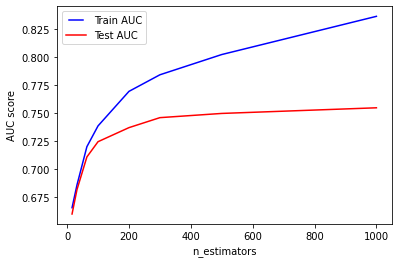

In [35]:
n_estimators = [16, 32, 64, 100, 200, 300, 500, 1000]
train_results = []
test_results = []

for estimator in n_estimators:
    model = GradientBoostingClassifier(n_estimators=estimator)
    model.fit(X_train, y_train)
    
    train_pred = model.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    y_pred = model.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.savefig('figures/estimators.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

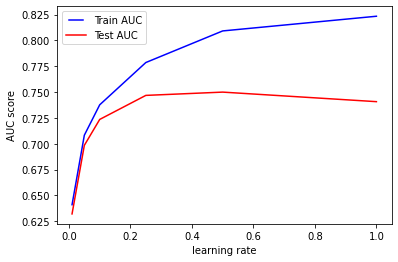

In [36]:
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
train_results = []
test_results = []

for eta in learning_rates:
    model = GradientBoostingClassifier(learning_rate=eta)
    model.fit(X_train, y_train)
    
    train_pred = model.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    y_pred = model.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(learning_rates, train_results, 'b', label='Train AUC')
line2, = plt.plot(learning_rates, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('learning rate')
plt.savefig('figures/learningrate.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

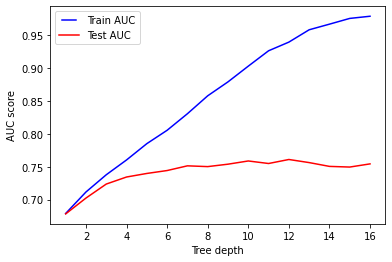

In [37]:
max_depths = np.linspace(1, 16, 16, endpoint=True)
train_results = []
test_results = []

for max_depth in max_depths:
    model = GradientBoostingClassifier(max_depth=max_depth)
    model.fit(X_train, y_train)
    
    train_pred = model.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    y_pred = model.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.savefig('figures/treedepth.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

Using the following parameters:
- `n_estimators= 300`
- `learning_rate = 0.50`
- `max_depth = 10`

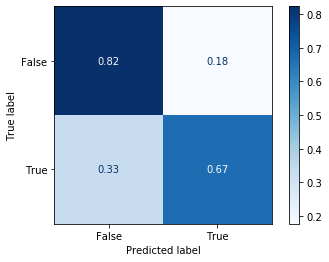

In [124]:
gb_clf2 = GradientBoostingClassifier(n_estimators=300, learning_rate=0.5, max_depth=10, random_state=0)
gb_clf2.fit(X_train, y_train)

y_pred = gb_clf2.predict(X_test)

metrics.plot_confusion_matrix(gb_clf2, X_test, y_test, cmap=plt.cm.Blues, normalize = 'true')
plt.savefig('figures/confusion_matrix.png', dpi=300, transparent=True, bbox_inches='tight')

In [125]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.78      0.82      0.80      4126
        True       0.73      0.67      0.70      2865

    accuracy                           0.76      6991
   macro avg       0.75      0.75      0.75      6991
weighted avg       0.76      0.76      0.76      6991



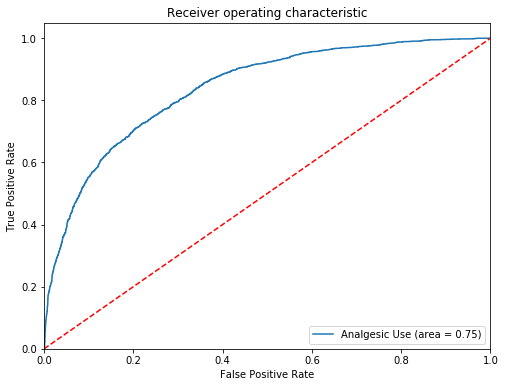

In [126]:
roc_auc = roc_auc_score(y_test, gb_clf2.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, gb_clf2.predict_proba(X_test)[:,1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Analgesic Use (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('figures/3C-ROC-pain.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

Without ordered protocols:
- `n = 113556 with 123364 visits (AUROC = 0.71)`

With ordered protocols:
- ` n = 21887 with 23301 visits (AUROC = 0.75)`
    - `Caucasian           17206`
    - `African American     2427`
    - `Hispanic             2149`
    - `Other/Unknown        1083`
    - `Asian                 338`
    - `Native American        98`
- `Trauma subset (n = 972 with 1007 visits)`
    - `Caucasian           823`
    - `Other/Unknown        65`
    - `African American     53`
    - `Hispanic             43`
    - `Asian                18`
    - `Native American       5`


In [128]:
import shap

shap_values = shap.TreeExplainer(gb_clf2).shap_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [226]:
X = pts.drop(columns=['painmeds','patienthealthsystemstayid','treatmentstring'])
y = pts.painmeds

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [228]:
d = pd.DataFrame(X_test)
d['truth'] = y_test
d['pred'] = y_pred

trues=d[(d.truth == True) & (d.pred == True)]

In [189]:
X_test.columns.get_loc("ethnicity_Hispanic")

1086

In [218]:
for person in list(trues.index):
    for x, i in enumerate(d.index):
        if i == person:
            idx = x
    
    k = X_test[idx]
            
    if k[1086] == 1: # originally native american
        original = 1086
        for num in range(1083,1089):
            k[1083] = 0
            k[1084] = 0
            k[1085] = 0
            k[1086] = 0
            k[1087] = 0
            k[1088] = 0
            k[num] = 1.0
            
            if (gb_clf2.predict([k]) == False) and (num != original):
                print("id:",idx, "ethnicity:", num)

id: 64 ethnicity: 1088
id: 464 ethnicity: 1083
id: 464 ethnicity: 1088
id: 1140 ethnicity: 1085
id: 1140 ethnicity: 1088
id: 1210 ethnicity: 1083
id: 1210 ethnicity: 1084
id: 1210 ethnicity: 1085
id: 1210 ethnicity: 1087
id: 1210 ethnicity: 1088
id: 1282 ethnicity: 1085
id: 1711 ethnicity: 1085
id: 2894 ethnicity: 1083
id: 2894 ethnicity: 1084
id: 2894 ethnicity: 1085
id: 2894 ethnicity: 1087
id: 2894 ethnicity: 1088
id: 3039 ethnicity: 1083
id: 3039 ethnicity: 1084
id: 3039 ethnicity: 1085
id: 3039 ethnicity: 1087
id: 3241 ethnicity: 1083
id: 3241 ethnicity: 1084
id: 3241 ethnicity: 1085
id: 3241 ethnicity: 1087
id: 3241 ethnicity: 1088
id: 4355 ethnicity: 1083
id: 4355 ethnicity: 1088
id: 4624 ethnicity: 1083
id: 4624 ethnicity: 1084
id: 4624 ethnicity: 1085
id: 4624 ethnicity: 1087
id: 4624 ethnicity: 1088
id: 4759 ethnicity: 1083
id: 4759 ethnicity: 1084
id: 4759 ethnicity: 1085
id: 4759 ethnicity: 1087
id: 4759 ethnicity: 1088


In [229]:
#3039 - originally hispanic & got pain meds but doesnt get pain meds if switched to native american

pt_dic = dict(d.iloc[3241])
pt_dic

{'patientunitstayid': 503508,
 'age': 28,
 'admissionheight': 154.9,
 'hospitaladmitoffset': -845,
 'hospitaldischargeoffset': 7074,
 'admissionweight': 63.5,
 'unitdischargeoffset': 2195,
 'max_pain': 6.0,
 'mean_pain': 2.0,
 'Antibiotic cycling': 0,
 'Cerebral vasospasm prevention/therapy': 0,
 'Congestive Heart Failure (CHF)': 0,
 'Electrolyte replacement': 0,
 'End of life': 0,
 'Glucose control': 0,
 'Hypothermia': 0,
 'Lung protective ventilation': 0,
 'Myocardial infarction': 0,
 'Other': 0,
 'Pressure ulcer prophylaxis': 0,
 'Sedation': 0,
 'Sepsis bundle': 1,
 'Spinal precautions': 0,
 'Steroid taper': 0,
 'Tissue Plasminogen Activator (tPA)': 0,
 'Ventilator bundle': 0,
 'Ventilator wean': 0,
 '005.9, A05.9': 0,
 '008.43, A04.5': 0,
 '008.45, A04.7': 0,
 '009.1, A09': 0,
 '011.60, A15.0': 0,
 '031.9, A31.9': 0,
 '036.0, A39.0': 0,
 '038.9, 348.31, R65.20, G93.41': 0,
 '038.9, 357.82, R65.20, G62.81': 0,
 '038.9, 359.81, R65.20, G72.81': 0,
 '038.9, 428.0, R65.20, I50.9': 0,
 

 `patientunitstayid': 503508`
 'gender': Female,
 'age': 28,
 'hospitalid': 142,
 'wardid': 256,
 'region': South,
 'diagnosis': Neurologic medical,
 'admissionheight': 154.9,
 'hospitaladmitsource': Emergency Department
 'hospitaladmitoffset': -845,
 'hospitaldischargeoffset': 7074,
 'admissionweight': 63.5,
 'unitdischargeoffset': 2195,
 'max_pain': 6.0,
 'mean_pain': 2.0,
 'ethnicity': Hispanic
 'orderedprotocols': Sepsis Bundle
 `Prediction: Pain Meds | Truth: Pain Meds`

In [251]:
pts[pts.patientunitstayid == 503508]

,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmitoffset,hospitaladmitsource,hospitaldischargeoffset,hospitaldischargelocation,hospitaldischargestatus,unittype,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,unitdischargeoffset,unitdischargelocation,unitdischargestatus,treatmentstring,painmeds,numbedscategory,teachingstatus,region,max_pain,mean_pain,icd9codes,orderedprotocols
28231,503508,426107,Female,28,Hispanic,142,256,"Neurologic medical, other",154.9,-845,Emergency Department,7074,Home,Alive,Med-Surg ICU,Emergency Department,1,admit,63.5,2195,Floor,Alive,neurologic|pain / agitation / altered mentatio...,True,>= 500,f,South,6.0,2.0,"[R51, 288.8, D72.829, 038.9, A41.9, 780.6, R50...",[Sepsis bundle]


In [130]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X_train.columns, vals)), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance.head(20)

,col_name,feature_importance_vals
1140,hospitalid_208,0.456701
5,unitdischargeoffset,0.324936
1853,unitadmitsource_Operating Room,0.304192
1147,hospitalid_227,0.282447
1891,region_Midwest,0.256524
25,Ventilator wean,0.213097
2,hospitaladmitoffset,0.210317
1146,hospitalid_226,0.207614
6,max_pain,0.202769
3,hospitaldischargeoffset,0.192515


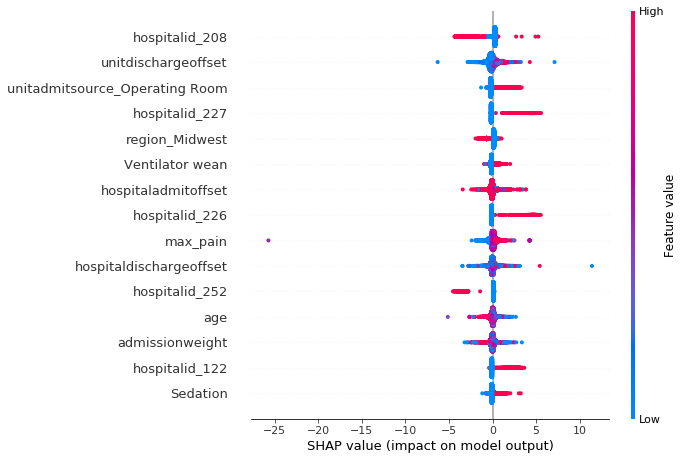

In [131]:
shap.summary_plot(shap_values, X_train, show=False, max_display=15)
plt.savefig('figures/3D-SHAPscorepain.png', dpi=300, transparent=True, bbox_inches='tight')

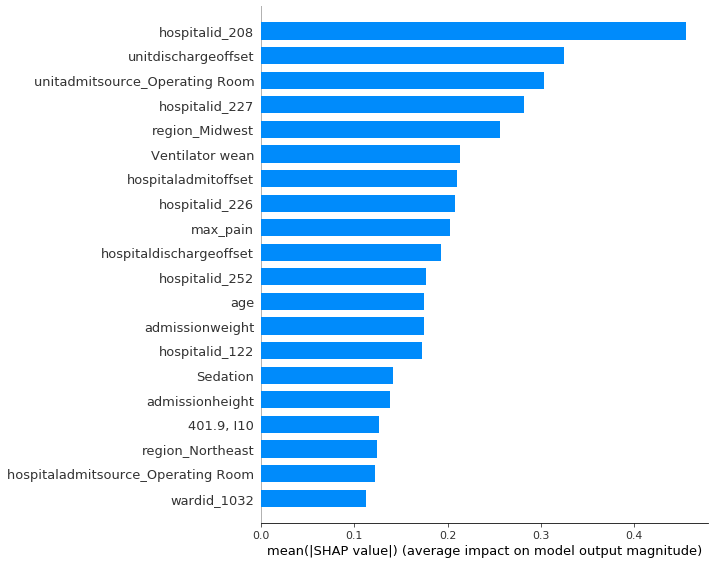

In [132]:
shap.summary_plot(shap_values, X_train, plot_type='bar')